In [1]:
!gdown --id 10fKUF1u3uhIrhEipoklNgysmPyYuYGV9 -O kaggle_m3.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10fKUF1u3uhIrhEipoklNgysmPyYuYGV9
To: /content/kaggle_m3.zip
100% 368M/368M [00:05<00:00, 65.1MB/s]


In [2]:
!gdown --id 1Leaos-3uB70Lex1qLE7FvrtaOBDOYKbQ -O data_aug.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Leaos-3uB70Lex1qLE7FvrtaOBDOYKbQ
To: /content/data_aug.zip
100% 123M/123M [00:02<00:00, 60.8MB/s]


In [3]:
! mkdir fakes

In [6]:
! cp data_aug.zip fakes

In [7]:
%cd fakes

/content/fakes


In [8]:
! ls

data_aug.zip


In [ ]:
! unzip data_aug.zip

In [10]:
%cd ..

/content


In [ ]:
!unzip kaggle_m3.zip

# Import Data

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import pandas as pd
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf

import os
import cv2
from PIL import Image
import numpy as np

In [13]:
# Set parameters
file_path='/'
Size = (256, 256)
mask_files = glob(file_path + os.path.join('content','*','*_mask*'))
train_files = [file.replace('_mask', '') for file in mask_files]

# Create Dataframe
def label(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image": train_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})


df.shape

(5302, 3)

In [14]:
# Collect Data
dataset = [ cv2.imread(path) for path in df["image"]  ]
label = df["label"].values
dataset = np.array(dataset)
label = np.array(df["label"].values).astype(int)
print(dataset.shape)
print(label.shape)

(5302, 256, 256, 3)
(5302,)


# Split Data

In [15]:
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

In [16]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# CNN

In [17]:
metrics = ['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

def model_builder(optimizer):
    INPUT_SHAPE = (256, 256, 3)   #change to (SIZE, SIZE, 3)


    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid')) 

    model.compile(
        optimizer=optimizer, 
        loss="binary_crossentropy", 
        metrics=metrics,
    )

    return model

## EarlyStopping

In [22]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

## Hyper Params

In [24]:
epochs = 1000
learning_rate = 0.0005
batch_size = 128

## Helper Functions

In [18]:
def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(888)

In [19]:
def plot_loss_and_acurracy(history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
  epochs = range(len(history.history['loss']))

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  axes[0].plot(epochs, loss, 'y', label='Training loss')
  axes[0].plot(epochs, val_loss, 'r', label='Validation loss')
  axes[0].set_title('Training and validation loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()

  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']
  axes[1].plot(epochs, acc, 'y', label='Training acc')
  axes[1].plot(epochs, val_acc, 'r', label='Validation acc')
  axes[1].set_title('Training and validation accuracy')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].legend()

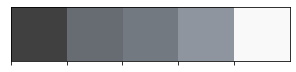

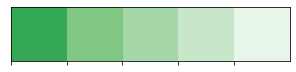

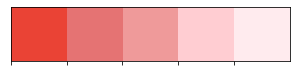

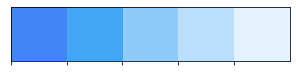

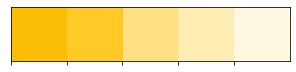

In [20]:
colors_dark = ["#404040", "#676c72", '#737980', '#8e959e', '#f9f9f9']
colors_red = ["#EA4335", "#E57373", '#EF9A9A', '#FFCDD2', '#FFEBEE']
colors_green = ['#34A853','#81C784','#A5D6A7','#C8E6C9','#E8F5E9']
colors_blue = ['#4285F4','#42A5F5','#90CAF9','#BBDEFB','#E3F2FD']
colors_yellow = ['#FBBC04','#FFCA28','#FFE082','#FFECB3','#FFF8E1']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)
sns.palplot(colors_blue)
sns.palplot(colors_yellow)

In [21]:
def plot_history_precision_recall(history):
    epochs = range(len(history.history['loss']))
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    train_acc = history.history['precision']
    train_loss = history.history['recall']
    val_acc = history.history['val_precision']
    val_loss = history.history['val_recall']

    fig.text(s='Epochs vs. Training and Validation Precision/Recall',size=18,fontweight='bold',
                 fontname='monospace',color=colors_dark[0],y=1,x=0.28,alpha=0.8)

    sns.despine()
    ax[0].plot(epochs, train_acc, color=colors_green[1],
               label = 'Training Precision')
    ax[0].plot(epochs, val_acc, color=colors_yellow[1],
               label = 'Validation Precision')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training & Validation Precision')

    sns.despine()
    ax[1].plot(epochs, train_loss, color=colors_green[1],
               label ='Training Recall')
    ax[1].plot(epochs, val_loss, color=colors_yellow[1],
               label = 'Validation Recall')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Recall')

    fig.show()

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from numpy.random import randint

import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())


def plot_roc_curve(models):
  auc_list = []

  plt.figure(figsize=(12, 8))
  plt.plot([0, 1], [0, 1], 'y--')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')

  for idx, (name, model) in enumerate(models):
    y_preds = model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_preds)
    auc_value = auc(fpr, tpr)
    auc_list.append(auc_value)
    label = str(name) + " - AUC: " + str(round(auc_value, 3))
    plt.plot(fpr, tpr, marker='.', color=colors_list[randint(len(colors_list) - 1)], label=label)

  plt.legend()
  
  return auc_list


## Optimizer - Adam

In [25]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
model_adam = model_builder(opt)

history_adam = model_adam.fit(X_train, 
                         y_train, 
                         batch_size = batch_size, 
                         verbose = 1, 
                         epochs = epochs,      
                         validation_data=(X_test,y_test),
                         shuffle = True,
                         callbacks=[es]
                     )

Epoch 1/1000
34/34 [==============================] - 28s 371ms/step - loss: 1.5712 - binary_accuracy: 0.7258 - precision: 0.7372 - recall: 0.7281 - val_loss: 0.6704 - val_binary_accuracy: 0.6032 - val_precision: 0.5760 - val_recall: 0.9301
Epoch 2/1000
34/34 [==============================] - 9s 276ms/step - loss: 0.6274 - binary_accuracy: 0.7779 - precision: 0.7866 - recall: 0.7815 - val_loss: 1.1184 - val_binary_accuracy: 0.4826 - val_precision: 0.8462 - val_recall: 0.0197
Epoch 3/1000
34/34 [==============================] - 9s 274ms/step - loss: 0.3995 - binary_accuracy: 0.8210 - precision: 0.8057 - recall: 0.8606 - val_loss: 2.2407 - val_binary_accuracy: 0.5259 - val_precision: 0.5259 - val_recall: 1.0000
Epoch 4/1000
34/34 [==============================] - 9s 279ms/step - loss: 0.3650 - binary_accuracy: 0.8380 - precision: 0.8195 - recall: 0.8798 - val_loss: 0.6471 - val_binary_accuracy: 0.6541 - val_precision: 0.6053 - val_recall: 0.9839
Epoch 5/1000
34/34 [===================

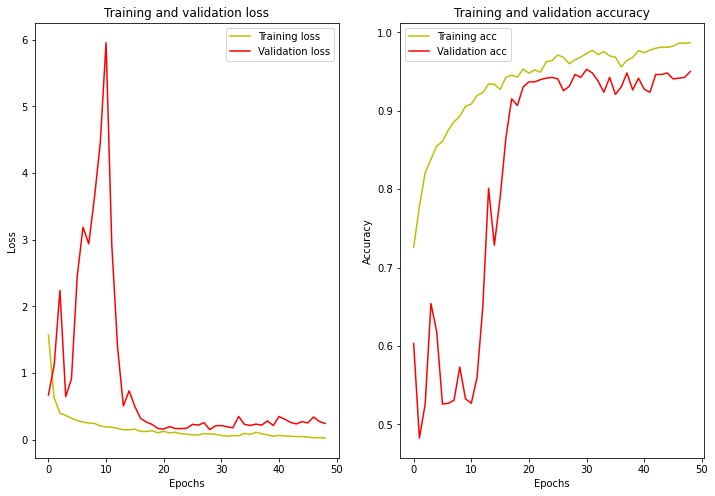

In [26]:
plot_loss_and_acurracy(history_adam)

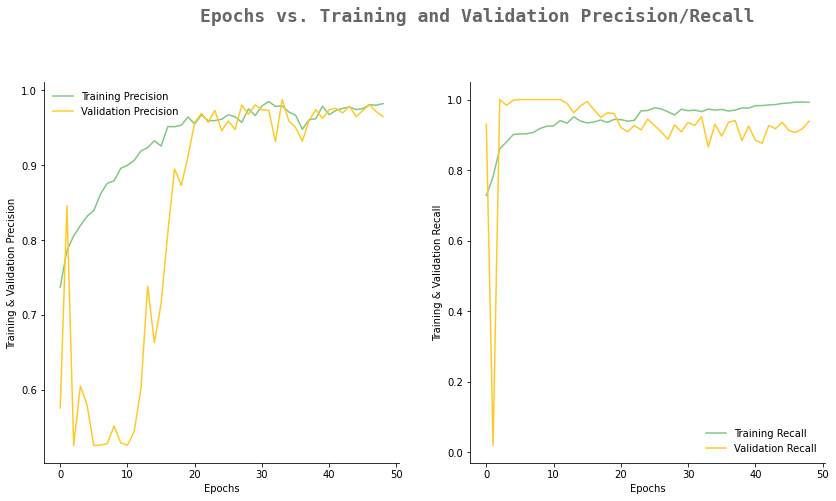

In [27]:
plot_history_precision_recall(history_adam)

In [28]:
model_adam.evaluate(X_test, y_test)

34/34 [==============================] - 1s 25ms/step - loss: 0.1516 - binary_accuracy: 0.9463 - precision: 0.9682 - recall: 0.9283


[0.15160825848579407,
 0.9462770819664001,
 0.968224287033081,
 0.9283154010772705]

[0.9889872236117346]

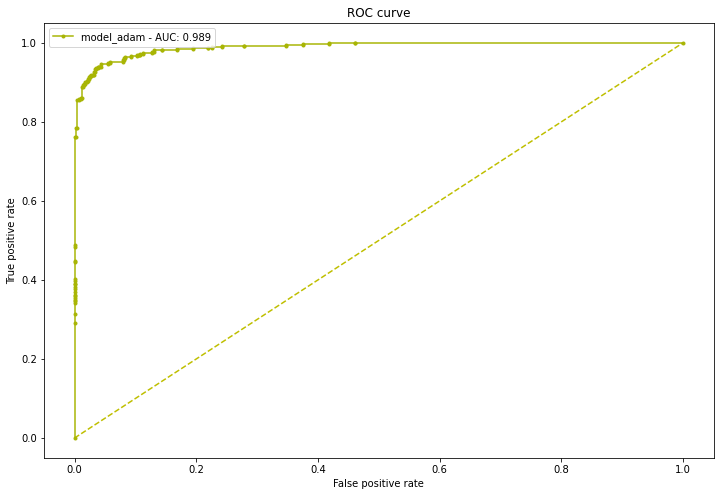

In [30]:
models = [("model_adam", model_adam)]

plot_roc_curve(models)

In [32]:
model_adam.save('cnn_model_full_dataset.h5')

# Transer Learning

In [33]:
IMAGE_SIZE = (256, 256, 3)

def make_model(transfer_model, learning_rate=learning_rate):
  model = transfer_model.output
  model = tf.keras.layers.Flatten()(model)
  model = tf.keras.layers.Dropout(rate=0.2)(model)
  model = tf.keras.layers.Dense(16, activation='relu')(model)
  model = tf.keras.layers.Dense(32, activation='relu')(model)
  model = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l1_l2')(model)
  model = tf.keras.models.Model(inputs=transfer_model.input, outputs = model)

  opt = tf.keras.optimizers.Adam(learning_rate= learning_rate, amsgrad=True)
  metrics = ['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

  model.compile(
          optimizer=opt, 
          loss="binary_crossentropy", 
          metrics=metrics,
      )

  return model

## EarlyStopping

In [42]:
# patient early stopping
es_transfer_learning = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

## MobileNet

In [37]:
transfer_model_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for l in transfer_model_mobilenet.layers:
# Freezing the model
  l.trainable = False

In [38]:
model_mobilenet = make_model(transfer_model_mobilenet)

In [39]:
history_mobilenet = model_mobilenet.fit(X_train, 
                    y_train, 
                    batch_size = 128, 
                    verbose = 1, 
                    epochs = 80,      
                    validation_data=(X_test,y_test),
                    callbacks=[es_transfer_learning]
                 )

Epoch 1/80
34/34 [==============================] - 13s 294ms/step - loss: 0.4902 - binary_accuracy: 0.8166 - precision_2: 0.7896 - recall_2: 0.8784 - val_loss: 0.3909 - val_binary_accuracy: 0.8860 - val_precision_2: 0.9524 - val_recall_2: 0.8244
Epoch 2/80
34/34 [==============================] - 7s 221ms/step - loss: 0.2827 - binary_accuracy: 0.9154 - precision_2: 0.9155 - recall_2: 0.9209 - val_loss: 0.2917 - val_binary_accuracy: 0.9142 - val_precision_2: 0.9679 - val_recall_2: 0.8656
Epoch 3/80
34/34 [==============================] - 8s 222ms/step - loss: 0.2107 - binary_accuracy: 0.9486 - precision_2: 0.9599 - recall_2: 0.9397 - val_loss: 0.2480 - val_binary_accuracy: 0.9321 - val_precision_2: 0.9500 - val_recall_2: 0.9194
Epoch 4/80
34/34 [==============================] - 8s 225ms/step - loss: 0.1496 - binary_accuracy: 0.9793 - precision_2: 0.9808 - recall_2: 0.9790 - val_loss: 0.2193 - val_binary_accuracy: 0.9406 - val_precision_2: 0.9575 - val_recall_2: 0.9283
Epoch 5/80
34/3

In [40]:
model_mobilenet.evaluate(X_test, y_test)

34/34 [==============================] - 2s 54ms/step - loss: 0.1788 - binary_accuracy: 0.9500 - precision_2: 0.9583 - recall_2: 0.9462


[0.1787669062614441,
 0.9500471353530884,
 0.9582577347755432,
 0.9462365508079529]

## VGG16

In [41]:
transfer_model_vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for l in transfer_model_vgg16.layers:
# Freezing the model
  l.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [43]:
model_vgg16 = make_model(transfer_model_vgg16)

history_vgg16 = model_vgg16.fit(X_train, 
                    y_train, 
                    batch_size = 128, 
                    verbose = 1, 
                    epochs = 80,      
                    validation_data=(X_test,y_test),
                    callbacks=[es_transfer_learning]
                 )

Epoch 1/80
34/34 [==============================] - 60s 1s/step - loss: 0.5305 - binary_accuracy: 0.7833 - precision_3: 0.7619 - recall_3: 0.8437 - val_loss: 0.4095 - val_binary_accuracy: 0.8549 - val_precision_3: 0.8620 - val_recall_3: 0.8620
Epoch 2/80
34/34 [==============================] - 36s 1s/step - loss: 0.3943 - binary_accuracy: 0.8451 - precision_3: 0.8248 - recall_3: 0.8885 - val_loss: 0.3693 - val_binary_accuracy: 0.8643 - val_precision_3: 0.9207 - val_recall_3: 0.8118
Epoch 3/80
34/34 [==============================] - 36s 1s/step - loss: 0.3613 - binary_accuracy: 0.8684 - precision_3: 0.8638 - recall_3: 0.8844 - val_loss: 0.3180 - val_binary_accuracy: 0.8907 - val_precision_3: 0.8696 - val_recall_3: 0.9319
Epoch 4/80
34/34 [==============================] - 36s 1s/step - loss: 0.3184 - binary_accuracy: 0.8885 - precision_3: 0.8786 - recall_3: 0.9095 - val_loss: 0.3080 - val_binary_accuracy: 0.8973 - val_precision_3: 0.9181 - val_recall_3: 0.8835
Epoch 5/80
34/34 [======

In [44]:
model_vgg16.evaluate(X_test, y_test)

34/34 [==============================] - 12s 226ms/step - loss: 0.1651 - binary_accuracy: 0.9482 - precision_3: 0.9548 - recall_3: 0.9462


[0.16508258879184723,
 0.9481621384620667,
 0.9547920227050781,
 0.9462365508079529]

# Save model to my drive

In [45]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [46]:
! pwd

/content


In [47]:
%cd ..

/


In [50]:
model_vgg16.save('transfer_model_vgg16_full_dataset.h5')

In [51]:
model_mobilenet.save('transfer_model_mobilenet_full_dataset.h5')

In [52]:
model_adam.save('cnn_model_full_dataset.h5')

# Final ROC Curve

[0.9889872236117346, 0.9893684488053756, 0.989820931044557]

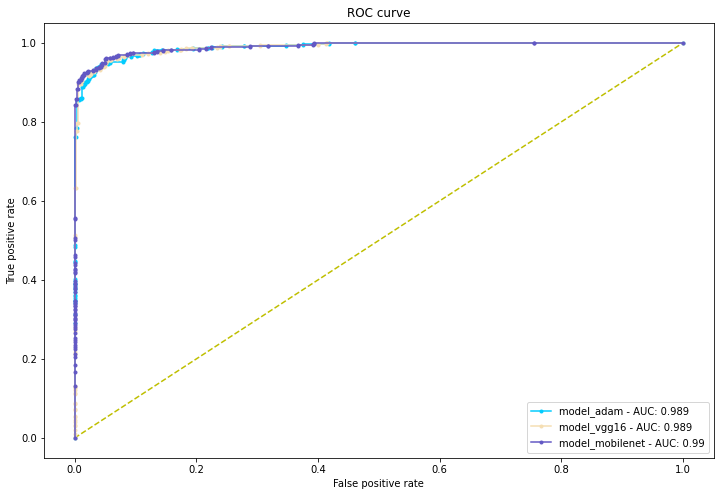

In [53]:
models = [("model_adam", model_adam), ("model_vgg16", model_vgg16), ("model_mobilenet", model_mobilenet)]

plot_roc_curve(models)